In [19]:
import sys
import os
print(sys.executable)
SRC_SUBDIR = '../..'
SRC_SUBDIR = os.path.abspath(SRC_SUBDIR)
if SRC_SUBDIR not in sys.path:
    print(f'Adding source directory to the sys.path: {SRC_SUBDIR!r}')
    sys.path.insert(1, SRC_SUBDIR)

/opt/homebrew/Caskroom/miniforge/base/envs/nlops/bin/python


In [20]:
print(sys.path)

['/opt/homebrew/Caskroom/miniforge/base/envs/nlops/lib/python314.zip', '/Volumes/Data/Projects/NLOperators', '/opt/homebrew/Caskroom/miniforge/base/envs/nlops/lib/python3.14', '/opt/homebrew/Caskroom/miniforge/base/envs/nlops/lib/python3.14/lib-dynload', '', '/opt/homebrew/Caskroom/miniforge/base/envs/nlops/lib/python3.14/site-packages']


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from src.operators.SympyWrapper import SympyWrap

In [22]:
rosenb_expr = "(a-x)**2+b*(y-x**2)**2"
rosenb = SympyWrap.from_string(rosenb_expr).partial_eval({"a":1, "b":100})
print(rosenb.symbols)
print(rosenb)

{x, y}
(1.0 - x)**2 + 100.0*(-x**2 + y)**2


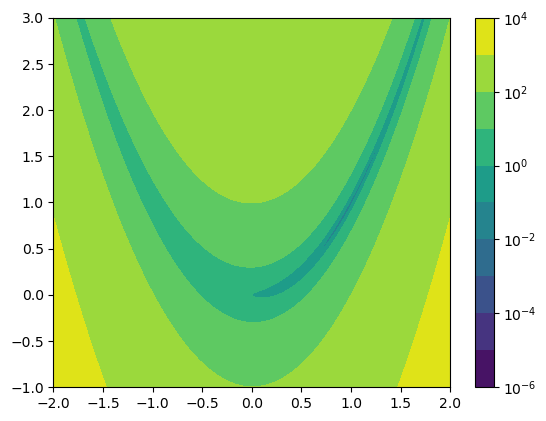

In [23]:
nx, ny = (400, 400)
xmin, xmax = -2,2
ymin, ymax =  -1,3
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
xv, yv = np.meshgrid(x, y)
xx= np.array([xv, yv])
vals = rosenb(xx, ['x','y'])
from matplotlib import ticker
fig, ax = plt.subplots()
im=plt.contourf(x,y,vals, locator=ticker.LogLocator(numticks=20))
plt.colorbar(im)
plt.show()

In [24]:
import copy
class GradientDescent:

    def __init__(self, func, vars, stepl=1.0, niters=10):
        self.func = func
        self.vars = vars
        self.stepl = stepl
        self.grad = func.jac(vars)
        self.niters = niters

    def compute_step(self, x, gx):
        return x - self.stepl*gx

    def solve(self, x0):
        x=copy.deepcopy(x0)
        iterations=[]
        for _ in range(self.niters):
            iterations.append(x)
            gx = self.grad(x,self.vars)
            x = self.compute_step(x, gx)
        return iterations


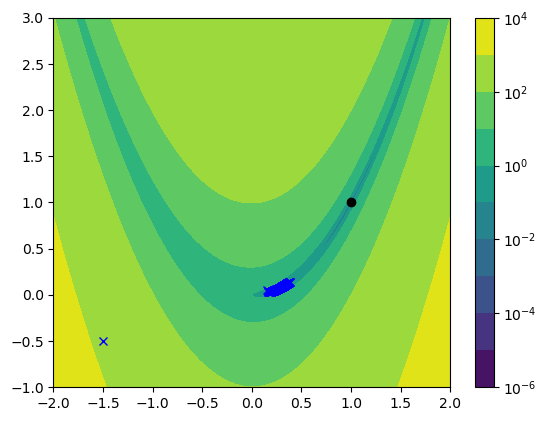

In [25]:
vars = ['x','y']
solver = GradientDescent(rosenb, vars, stepl=0.001, niters=200)
x0 = np.array([-1.5,-0.5])
iterations = solver.solve(x0)
for iteration in iterations:
    xiteration, yiteration = iteration  
    plt.plot(xiteration, yiteration, marker='x', color='b', linestyle='none')
plt.plot([1], [1], marker='o', color='k', linestyle='none')
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))
im=plt.contourf(x,y,vals, locator=ticker.LogLocator(numticks=20))
plt.colorbar(im)
plt.show()

In [26]:
class NewtonDescent(GradientDescent):

    def __init__(self, func, vars, niters=10):
        super().__init__(func, vars, 1.0, niters)
        self.hess = self.grad.jac(vars)

    def compute_step(self, x, gx):
        Hx = self.hess(x,self.vars)
        return x-np.linalg.inv(Hx).dot(gx)
    

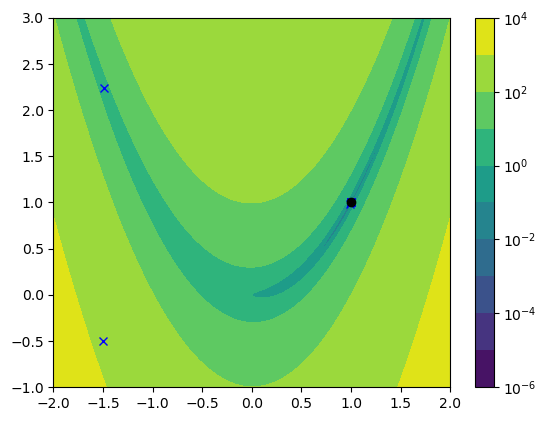

In [27]:
vars = ['x','y']
solver = NewtonDescent(rosenb, vars, niters=10)
iterations = solver.solve(x0)
for iteration in iterations:
    xiteration, yiteration = iteration  
    plt.plot(xiteration, yiteration, marker='x', color='b', linestyle='none')
plt.plot([1], [1], marker='o', color='k', linestyle='none')
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))
im=plt.contourf(x,y,vals, locator=ticker.LogLocator(numticks=20))
plt.colorbar(im)
plt.show()